In [56]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn import linear_model


%matplotlib inline

In [57]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [58]:
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']])
price = train["SalePrice"]
num_train = train.shape[0]
num_test = test.shape[0]

#eliminate the columns that contain too much NAN
temp = all_data.isnull().sum()
ratio = temp/all_data.shape[0]
cols = ratio > 0.3
print(cols)
all_data = all_data.drop(all_data.columns[cols],axis =1 )

print(all_data.shape)
all_data.head(10)

MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType       False
MasVnrArea       False
ExterQual        False
ExterCond        False
Foundation       False
BsmtQual         False
                 ...  
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual      False
TotRmsAbvGrd     False
Functional       False
Fireplaces       False
FireplaceQu       True
GarageType       False
GarageYrBlt      False
GarageFinish     False
GarageCars       False
GarageArea 

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,30,0,320,0,0,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,57,0,0,0,0,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,204,228,0,0,0,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,205,0,0,0,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,4,0,0,0,0,0,1,2008,WD,Normal


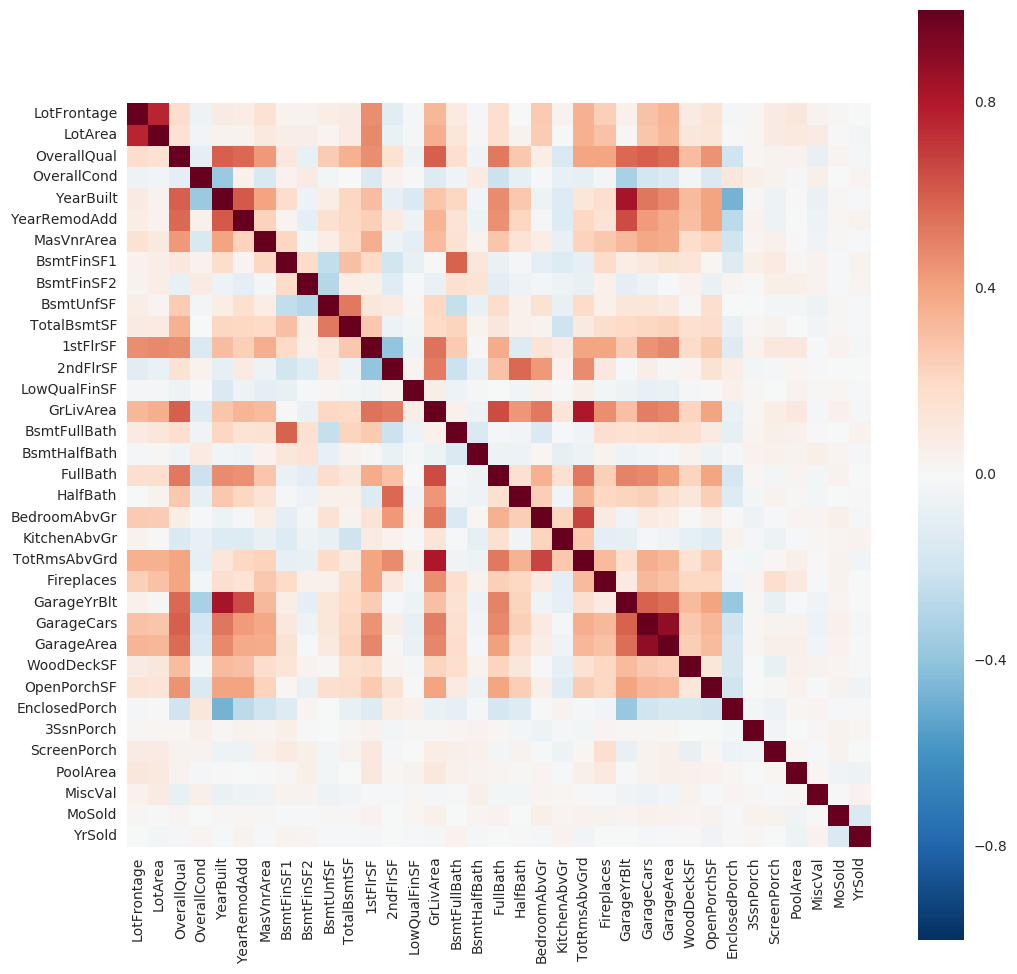

In [78]:
#see the correlation between each feature
import seaborn as sns


alldata = pd.concat([all_data.iloc[:num_train],price], axis = 1)
alldata.head(10)


corr = all_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)



In [79]:
#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
price = np.log(price+1)
print(price)

0       1.276430
1       1.273490
2       1.277889
3       1.267876
4       1.280221
5       1.268340
6       1.284431
7       1.275552
8       1.266230
9       1.264099
10      1.266162
11      1.286787
12      1.268492
13      1.282517
14      1.270372
15      1.266584
16      1.269236
17      1.257980
18      1.270646
19      1.267719
20      1.285603
21      1.267782
22      1.278488
23      1.266230
24      1.269954
25      1.280735
26      1.267045
27      1.284365
28      1.276329
29      1.251637
          ...   
1430    1.274702
1431    1.268454
1432    1.250214
1433    1.274069
1434    1.270781
1435    1.272587
1436    1.264566
1437    1.289469
1438    1.269338
1439    1.275232
1440    1.274576
1441    1.269280
1442    1.284628
1443    1.264658
1444    1.273265
1445    1.266076
1446    1.270496
1447    1.279374
1448    1.262934
1449    1.258483
1450    1.267240
1451    1.283065
1452    1.268643
1453    1.256531
1454    1.273897
1455    1.272710
1456    1.276581
1457    1.2815

In [80]:
all_data = pd.get_dummies(all_data)

In [81]:
#fill the missing data with mean value
alldata_avg = all_data.fillna(all_data.mean())
alldata_avg.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [82]:
#number of missdata for each columns
missdata = all_data.isnull().sum()
print(missdata)

#the columns contain missing value
miss_cols = all_data.columns[(missdata != 0)]
print(miss_cols)   


#alldata_fill ==> fill the missing value with prediction from other existing value (lasso regression model) 
train_x = all_data[:train.shape[0]]
train_miss = train_x.drop(miss_cols,axis =1)
alldata_fill = all_data

for col in miss_cols:
    miss_train = train_x[col].isnull()
    miss_all = all_data[col].isnull()   
    
    nanTrain = train_miss.drop(train_miss.index[miss_train])
    nanTrain_value = train_x[col].drop(train_miss.index[miss_train])
    reg = linear_model.Lasso(alpha = 0.1)
    miss_data = train_miss.ix[miss_all.index]
    reg.fit(nanTrain,nanTrain_value)
    temp = reg.predict(miss_data)
    alldata_fill[col][miss_all] = temp

MSSubClass                 0
LotFrontage              486
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
YearRemodAdd               0
MasVnrArea                23
BsmtFinSF1                 1
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
GrLivArea                  0
BsmtFullBath               2
BsmtHalfBath               2
FullBath                   0
HalfBath                   0
BedroomAbvGr               0
KitchenAbvGr               0
TotRmsAbvGrd               0
Fireplaces                 0
GarageYrBlt              159
GarageCars                 1
GarageArea                 1
WoodDeckSF                 0
OpenPorchSF                0
EnclosedPorch              0
                        ... 
GarageFinish_RFn           0
GarageFinish_Unf           0
GarageQual_Ex              0
GarageQual_Fa 

C:\Users\Mission\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [83]:
train = alldata_fill[:train.shape[0]]
x_train = alldata_fill[:train.shape[0]]
x_test = alldata_fill[train.shape[0]:]
y_train = price
alldata_fill.head(10)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.00000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,3.931826,4.454347,9.555064,5,5,1993,1995,0.000000,6.597146,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,3.044522,4.330733,9.218804,8,5,2004,2005,5.231109,7.222566,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,4.110874,4.227372,9.247925,7,6,1973,1973,5.484797,6.756932,0.91761,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,3.931826,3.951244,8.719481,7,5,1931,1950,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,5.252273,3.931826,8.912069,5,6,1939,1950,0.000000,6.747587,0.00000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


[ 1.26488689  1.26988724  1.27413115 ...,  1.27227451  1.2645587
  1.27720289]


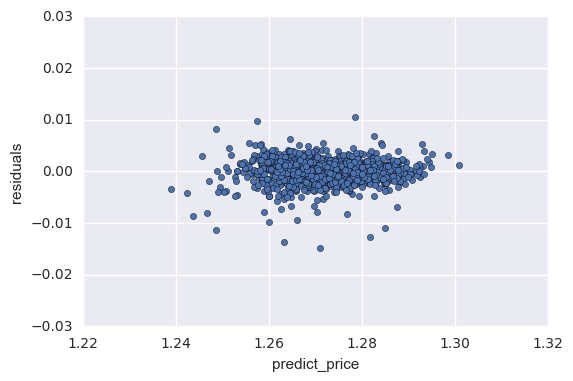

In [84]:
#fit into regrssion model
from sklearn import linear_model

Ridgemodel = linear_model.RidgeCV(alphas=[0.02,1.0,10.0],normalize = True)
Ridgemodel.fit(x_train,y_train)
y_pred = Ridgemodel.predict(x_test)
print(y_pred)

preds = pd.DataFrame({"predict_price":Ridgemodel.predict(x_train),"price":y_train})
preds["residuals"] = preds["price"] - preds["predict_price"]
preds.plot(x = "predict_price",y = "residuals", kind = "scatter")

In [ ]:
Models
Now we are going to use regularized linear regression models from the scikit learn module.

C:\Users\Mission\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Mission\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Mission\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Mission\Anaconda3\lib\site-packages\sklearn\metrics\scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
C:\Users\Mission\Anaconda3\l

[0.0030421150638274661, 0.0062120949986244484, 0.0065714961325945825, 0.0067012576296331099, 0.0080445795277204919, 0.0085935625678138592]


C:\Users\Mission\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


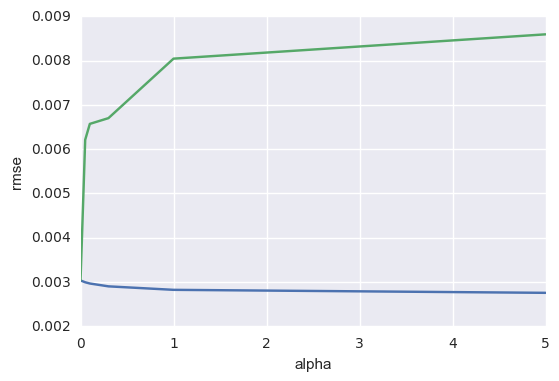

In [85]:
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import Ridge, RidgeCV

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="mean_squared_error", cv = 5))
    return(rmse)

alphas = [0.0001,0.05, 0.1, 0.3, 1,5]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean()  for alpha in alphas]

cv_lasso = [rmse_cv(linear_model.Lasso(alpha = alpha, max_iter = 1500)).mean()  for alpha in alphas]
print(cv_lasso)

cv_ridge = pd.Series(cv_ridge, index = alphas)
plt.plot(alphas, cv_ridge)
plt.plot(alphas, cv_lasso)
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.legend()
plt.show()

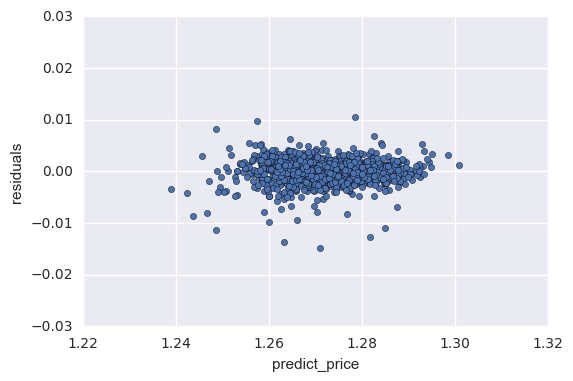

In [86]:
#look at the residuals as well:
preds = pd.DataFrame({"predict_price":Ridgemodel.predict(x_train),"price":y_train})
preds["residuals"] = preds["price"] - preds["predict_price"]
preds.plot(x = "predict_price",y = "residuals", kind = "scatter")


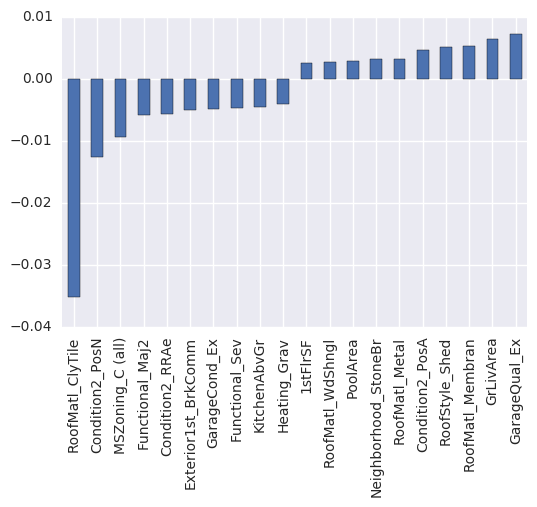

In [87]:
#take a look at what the most important coefficients are:
coef = pd.Series(Ridgemodel.coef_, index  = x_train.columns)
key_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
key_coef.plot(kind = "bar")



In [ ]:
DNN model with Kera

In [88]:
import keras
import pickle
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


##define base model
def base_model(optimizer='rmsprop', init='glorot_uniform'):
     model = Sequential()
     model.add(Dense(128, input_dim=270, init='normal', activation='relu'))
     model.add(Dropout(0.2))
     model.add(Dense(64, init=init, activation='relu'))
     model.add(Dropout(0.2))
     model.add(Dense(64, init=init, activation='relu'))
     model.add(Dropout(0.2))
     model.add(Dense(1, init=init))
     model.compile(loss='mean_squared_error', optimizer=optimizer)       
     return model

y_train = np.array(y_train)
x_train = np.array(x_train)
x_test = np.array(x_test)

#create regresion model
model = KerasRegressor(build_fn=base_model,batch_size=5,verbose=0)

#gridsearch epoch,batch size and optimizer
optimizers = ['sgd','adam','RMSprop']
inits = ['normal','uniform','glorot_uniform']
epochs = [100]
batches = [5,10,20]
param_grids = dict(optimizer = optimizers, init = inits,nb_epoch = epochs ,batch_size = batches) 

grid = GridSearchCV(estimator = model, param_grid = param_grids )
grid_result = grid.fit(x_train,y_train)

#summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))





Best: 0.011983 using {'batch_size': 20, 'nb_epoch': 100, 'optimizer': 'adam', 'init': 'glorot_uniform'}


In [89]:
score = np.sqrt(mean_squared_error(y_train, grid_result.best_estimator_.predict(x_train)))
print(score)

y_pred_keras = grid_result.best_estimator_.predict(x_test)


0.0135132675425
